In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

END_LR = 3E-3
LR_FACTOR = 6

min_lr = END_LR / LR_FACTOR
max_lr = END_LR

shape_type = 'triangular'
decay_type = 'step_decay'

epoch_count = 30
epochs_per_step = 4  # epochs per step

batch_size = 2  # datapoints per batch (limited by GPU memory)
dataset_size = 5

batch_count = math.ceil(dataset_size / batch_size)  # batches per epoch
step_size = epochs_per_step * batch_count  # batches per step

# step = lambda it: math.floor(1 + it / step_size)
# cycle = lambda it: math.floor(1 + it / (2 * step_size))
# epoch = lambda it: math.floor(it / batch_count)

In [2]:
# epochs = []
# cycles = []
# steps = []
# for i in range(batch_count * epoch_count):
#     steps.append(step(i))   
#     cycles.append(cycle(i))
#     epochs.append(epoch(i))

In [3]:
# df=pd.DataFrame({'x': range(batch_count * epoch_count), 
#                  'epochs': epochs, 
#                  'cycles': cycles, 
#                  'steps': steps})
 
# # multiple line plot
# plt.plot( 'x', 'epochs', data=df)
# plt.plot( 'x', 'cycles', data=df)
# plt.plot( 'x', 'steps', data=df)
# plt.legend()

In [4]:
def decay_function(decay_type, epochs_per_step):   
    if decay_type == 'no_decay':
        decay = lambda current_epoch: 1.
    elif decay_type == 'step_decay':
        drop = 0.5
        decay = lambda current_epoch: math.pow(drop, math.floor(1 + current_epoch / (2 * epochs_per_step)))
    elif decay_type == 'exp_decay':
        k = 0.1
        decay = lambda current_epoch: math.exp(-k * current_epoch)
    elif decay_type == 'time_decay':
        decay_time = 0.1
        decay = lambda current_epoch: 1. / (1. + decay_time * current_epoch)

    return decay

In [5]:
def shape_function(shape_type, step_size):
    if shape_type == 'flat':
        shape = lambda it: 1.
    elif shape_type == 'triangular':
        # for a given iteration, determines which cycle it belongs to
        # note that a cycle is 2x steps in the triangular waveform
        cycle = lambda it: math.floor(1 + it / (2 * step_size))

        shape = lambda it: max(0, (1 - abs(it / step_size - 2 * cycle(it) + 1)))

    return shape

In [6]:
def cyclical_lr(batch_count, shape, decay, min_lr=3e-4, max_lr=3e-3):
    epoch = lambda it: math.floor(it / batch_count)

    # Lambda function to calculate the LR
    lr_lambda = lambda it: min_lr + (max_lr - min_lr) * shape(it) * decay(epoch(it))

    return lr_lambda


In [7]:
clr = cyclical_lr(batch_count,
                  shape=shape_function(shape_type, step_size),
                  decay=decay_function(decay_type, epochs_per_step),
                  min_lr=min_lr,
                  max_lr=max_lr,
                  )

In [8]:
batch_num = 0
all_lrs = []

for current_epoch in range(epoch_count):
    lrs = []
    for j in range(batch_count):
        # this is equivalent to calling scheduler.step() once per batch
        lrs.append(clr(batch_num))
        batch_num += 1

    all_lrs.append(lrs)

In [9]:
combined_lrs = []
for lrs in all_lrs:
    combined_lrs.extend(lrs)
    
combined_lrs

[0.0005,
 0.0006041666666666666,
 0.0007083333333333334,
 0.0008125000000000001,
 0.0009166666666666665,
 0.0010208333333333334,
 0.0011250000000000001,
 0.001229166666666667,
 0.001333333333333333,
 0.0014375,
 0.0015416666666666669,
 0.0016458333333333331,
 0.00175,
 0.0016458333333333336,
 0.0015416666666666667,
 0.0014375,
 0.0013333333333333335,
 0.0012291666666666666,
 0.0011250000000000001,
 0.0010208333333333334,
 0.0009166666666666665,
 0.0008125000000000001,
 0.0007083333333333334,
 0.0006041666666666666,
 0.0005,
 0.0005520833333333335,
 0.0006041666666666666,
 0.00065625,
 0.0007083333333333334,
 0.0007604166666666666,
 0.0008125000000000001,
 0.0008645833333333335,
 0.0009166666666666665,
 0.00096875,
 0.0010208333333333334,
 0.0010729166666666665,
 0.0011250000000000001,
 0.0010729166666666665,
 0.0010208333333333334,
 0.00096875,
 0.0009166666666666665,
 0.0008645833333333335,
 0.0008125000000000001,
 0.0007604166666666666,
 0.0007083333333333334,
 0.00065625,
 0.0006041

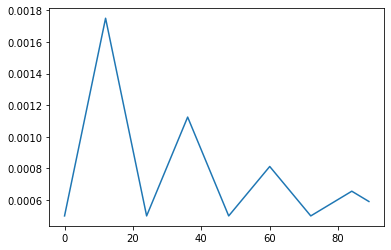

In [10]:
plt.plot(combined_lrs)

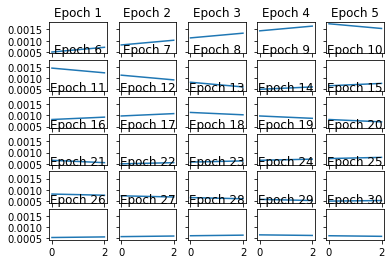

In [11]:
plot_columns = 5
plot_rows = math.ceil(epoch_count / plot_columns)

fig, axs = plt.subplots(plot_rows, plot_columns, sharex=True, sharey=True)

for current_epoch in range(epoch_count):
    row = math.floor(current_epoch / plot_columns)
    column = current_epoch % plot_columns
    axs[row, column].plot(all_lrs[current_epoch])
    axs[row, column].set_title(f'Epoch {current_epoch + 1}')